In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from pathlib import Path
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from experiments.configs.regression_consts import VALID_UQ_METHODS, VALID_ESTIMATORS, MODELS, SINGLE_CONFORMAL_METHODS
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,              # Use TeX for text rendering
    "font.family": "serif",
    "hatch.color": "white"
})
%load_ext autoreload
%autoreload 2

# Ablation Experiment 1: Vary Number of Bootstraps for PCS

In [937]:
DATASETS = ["data_ca_housing", "data_diamond", "data_parkinsons", "data_airfoil"]
SEEDS = [777, 778, 779, 780, 781, 782, 783, 784, 785, 786]
NBOOTS = [25, 50, 100, 500, 1000]
RESULT_PATH = Path('../results/ablation/boot')

In [926]:
agg_results_dict = {}
for data in DATASETS:
    for n_boot in NBOOTS:
        dataset_path = RESULT_PATH / data
        agg_results_dict[(data, n_boot)] = {}
        file = pickle.load(open(f'{dataset_path}/pcs_oob_train_size_0.8_nboot_{n_boot}_train_frac_1.0_ablation_agg_metrics.pkl', 'rb'))
        for metric_cat, metric_dict in file.items():
            for metric_name, metric_value in metric_dict.items():
                if metric_name in ['values', 'seeds']:
                    continue
                agg_results_dict[(data, n_boot)][f'{metric_cat}_{metric_name}'] = metric_value

In [927]:
df = pd.DataFrame.from_dict(agg_results_dict, orient='index')
df = df.reset_index().rename(columns={"level_0": "data",
                                      'level_1': "n_boot"})
df['data'] = df['data'].map(lambda x: x.split('_')[1].capitalize())
df.loc[df['data'] == 'Ca', 'data'] = 'CA'

In [928]:
data_colors_dict={'CA': '#CEB43C', 
                  'Diamond': '#FFB933', 
                  'Parkinsons': '#ec6d18', 
                  'Airfoil': '#90462c'}

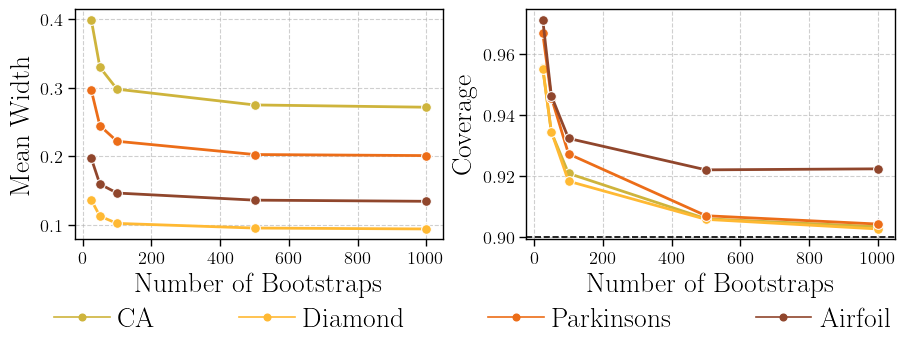

In [929]:
sns.set_context("paper", font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(9,3))

# main plots
# sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], marker='o', hue='data')
# sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], marker='o', hue='data', legend=False)
# sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], style='data', color='orange', marker='o')
# sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], style='data', color='orange', legend=False)

sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], hue='data', marker='o', palette=data_colors_dict, legend=False, linewidth=2, markersize=7)
sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], marker='o', hue='data', palette=data_colors_dict, legend=False, linewidth=2, markersize=7)
# error bars
# for data, color in zip(df['data'].unique(), sns.color_palette()):
#     data_df = df[df['data'] == data]
#     axes[0].errorbar(data_df['n_boot'], data_df['mean_width_scaled_mean'], yerr=data_df['mean_width_scaled_std'], fmt='none', capsize=3, ecolor=color)
#     axes[1].errorbar(data_df['n_boot'], data_df['coverage_mean'], yerr=data_df['coverage_std'], fmt='none', capsize=3, ecolor=color)

# make legend
handles = []
unique_methods = df['data'].unique()
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], 
                              marker='o', color=data_colors_dict[method], 
                              label=method, linestyle='-'))
legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=3, fontsize=20, 
            ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.16),
            handletextpad=0.3, borderaxespad=0.3, frameon=False)

# some customization
#axes[0].legend(title="", loc='lower center', bbox_to_anchor=(1.05, -0.42), ncol=5, frameon=False)
axes[0].set_xlabel("Number of Bootstraps", fontsize=20)
axes[0].set_ylabel("Mean Width", fontsize=20)
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].set_xlabel("Number of Bootstraps", fontsize=20)
axes[1].set_ylabel("Coverage", fontsize=20)
axes[1].axhline(0.9, color='black', linestyle='--')
axes[1].grid(True, linestyle='--', alpha=0.6)

fig.tight_layout(pad=0.3)
fig.savefig('figures/ablation_nboot.pdf', bbox_inches='tight')

# Ablation Experiment 2: Varying Fraction of Training Set Used

In [866]:
DATASETS = ["data_ca_housing", "data_diamond", "data_parkinsons", "data_airfoil"]
SEEDS = [777, 778, 779, 780, 781, 782, 783, 784, 785, 786]
TRAIN_FRACS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
RESULT_PATH = Path('../results/ablation/split')
METHODS = [('pcs_oob', ''),('split_conformal', 'XGBoost'), ('studentized_conformal', 'RandomForest'), ('majority_vote', '')]
n_boot = 1000

In [867]:
agg_results_dict = {}
for data in DATASETS:
    for train_frac in TRAIN_FRACS:
        dataset_path = RESULT_PATH / data
        for method in METHODS:
            agg_results_dict[(data, train_frac, method[0], method[1])] = {}
            method_est = method[0] + '_' + method[1]
            if method[0] == 'pcs_oob' or method[0] == 'majority_vote':
                method_est = method[0]
            file = pickle.load(open(f'{dataset_path}/{method_est}_train_size_0.8_nboot_{n_boot}_train_frac_{train_frac}_ablation_agg_metrics.pkl', 'rb'))
            for metric_cat, metric_dict in file.items():
                for metric_name, metric_value in metric_dict.items():
                    if metric_name in ['values', 'seeds']:
                        continue
                    agg_results_dict[(data, train_frac, method[0], method[1])][f'{metric_cat}_{metric_name}'] = metric_value

In [868]:
df = pd.DataFrame.from_dict(agg_results_dict, orient='index')
df = df.reset_index().rename(columns={"level_0": "data",
                                      'level_1': "train_frac",
                                      'level_2': "method",
                                      'level_3': "estimator"})
df['data'] = df['data'].map(lambda x: x.split('_')[1].capitalize())
df.loc[df['data'] == 'Ca', 'data'] = 'CA'

In [869]:
df_lst = []
for data in df['data'].unique():
    for train_frac in df['train_frac'].unique():
        df_subset = df[(df['data'] == data) & (df['train_frac'] == train_frac)].copy(deep=True)
        pcs_width = df_subset[df_subset['method'] == 'pcs_oob']['mean_width_scaled_mean'].values[0]
        df_subset.loc[:,'width_reduction'] = (df_subset['mean_width_scaled_mean'] - pcs_width) / df_subset['mean_width_scaled_mean']
        df_lst.append(df_subset)
df = pd.concat(df_lst, ignore_index=True)
df

,data,train_frac,method,estimator,coverage_mean,coverage_std,mean_width_mean,mean_width_std,median_width_mean,median_width_std,mean_width_scaled_mean,mean_width_scaled_std,median_width_scaled_mean,median_width_scaled_std,width_reduction
0,CA,0.1,pcs_oob,,0.899806,0.014501,214892.440535,26795.811506,191963.655057,19389.017701,0.445991,0.056804,0.398346,0.040891,0.000000
1,CA,0.1,split_conformal,XGBoost,0.904046,0.014485,245802.453125,18215.617188,245802.453125,18215.625000,0.510033,0.038555,0.510033,0.038555,0.125563
2,CA,0.1,studentized_conformal,RandomForest,0.893290,0.020055,221682.833942,17923.328166,210039.889967,16761.685390,0.460076,0.038936,0.435920,0.036521,0.030613
3,CA,0.1,majority_vote,,0.957873,0.015029,331524.699123,24385.873971,329697.435640,24378.263895,0.687868,0.050941,0.684090,0.051125,0.351632
4,CA,0.2,pcs_oob,,0.902931,0.007719,163619.548977,5096.724962,152686.308976,5512.921210,0.339536,0.012599,0.316853,0.013219,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Airfoil,0.9,majority_vote,,0.973090,0.012471,19.326477,0.730281,19.344697,0.798897,0.564984,0.027380,0.565533,0.029105,0.749060
156,Airfoil,1.0,pcs_oob,,0.922259,0.011039,4.594301,0.173649,4.158705,0.161088,0.134421,0.008486,0.121751,0.008808,0.000000
157,Airfoil,1.0,split_conformal,XGBoost,0.913953,0.023372,6.869988,0.459642,6.869988,0.459642,0.200729,0.013416,0.200729,0.013416,0.330334
158,Airfoil,1.0,studentized_conformal,RandomForest,0.914618,0.024730,11.839717,0.315038,11.840405,0.702394,0.346233,0.016474,0.345899,0.018704,0.611762


In [870]:
colors_dict = {'pcs_oob': 'orange', 'split_conformal': '#B2746B', 'studentized_conformal': '#697fa0', 'majority_vote': '#86a76c'}
markers_dict = {'pcs_oob': 'X', 'split_conformal': 'o', 'studentized_conformal': '^', 'majority_vote': 's'}
colors_dict_formal = {'PCS': 'orange', 'Split Conformal (XGBoost)': '#B2746B', 'Studentized Conformal (Random Forest)': '#697fa0', 'Majority Vote': '#86a76c'}
markers_dict_formal = {'PCS': 'X', 'Split Conformal (XGBoost)': 'o', 'Studentized Conformal (Random Forest)': '^', 'Majority Vote': 's'}
informal_to_formal = {'pcs_oob': 'PCS', 'split_conformal': 'Split Conformal (XGBoost)', 'studentized_conformal': 'Studentized Conformal (Random Forest)', 'majority_vote': 'Majority Vote'}

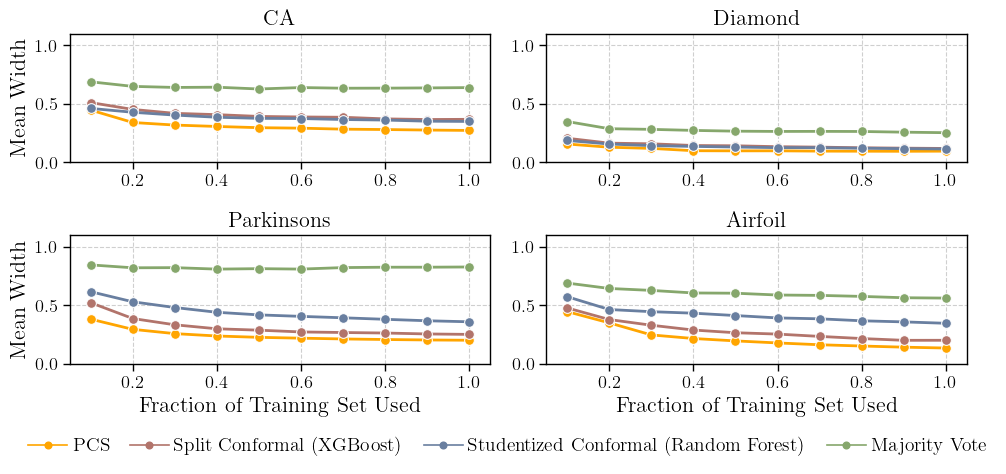

In [874]:
sns.set_context("paper", font_scale=1.5)

fig, axes = plt.subplots(2,2, figsize=(10, 4.5))

# main plot
for data, ax in zip(df['data'].unique(), axes.flatten()):
    data_df = df[df['data'] == data]
    sns.lineplot(data=data_df, x='train_frac', y='mean_width_scaled_mean', ax=ax, marker="o", hue='method', palette=colors_dict, legend=False, linewidth=2, markersize=7)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0.05, 1.05)
    ax.set_xlabel("Fraction of Training Set Used", fontsize=16)
    ax.set_ylabel("Mean Width", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title(data, fontsize=16)
    
# df = df.query('method != "pcs_oob"')  # remove pcs_oob for the width reduction plot
# for data, ax in zip(df['data'].unique(), axes.flatten()):
#     data_df = df[df['data'] == data]
#     sns.lineplot(data=data_df, x='train_frac', y='width_reduction', ax=ax, marker="o", hue='method', palette=colors_dict, legend=False)
#     ax.set_ylim(-0.1, 1.1)
#     ax.set_xlim(0.05, 1.05)
#     ax.set_xlabel("Fraction of Training Set Used")
#     ax.set_ylabel("")
#     ax.grid(True, linestyle='--', alpha=0.6)
#     ax.set_title(data)
#     ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))

# make legend
handles = []
unique_methods = [informal_to_formal[method] for method in df.method.unique()]
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], 
                              marker='o', color=colors_dict_formal[method], 
                              label=method, linestyle='-'))
legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=1, fontsize=14, 
            ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.07),
            handletextpad=0.3, borderaxespad=0.3, frameon=False)

# remove some axis labels
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
#fig.text(0, 0.5, '\% Width Reduction of PCS', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()
fig.savefig('figures/ablation_split.pdf', bbox_inches='tight')

# Ablation Experiment 3: Varying Number of Models

In [919]:
DATASETS = ["data_ca_housing", "data_diamond", "data_parkinsons", "data_airfoil"]
SEEDS = [777, 778, 779, 780, 781, 782, 783, 784, 785, 786]
RESULT_PATH = Path('../results/ablation/model')
NMODELS = [1,2,3,4,5]
n_boot = 1000

In [920]:
agg_results_dict = {}
for data in DATASETS:
    for n_model in NMODELS:
        agg_results_dict[(data, n_model)] = {}
        dataset_path = RESULT_PATH / data
        file = pickle.load(open(f'{dataset_path}/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_{n_model}_ablation_agg_metrics.pkl', 'rb'))
        for metric_cat, metric_dict in file.items():
            for metric_name, metric_value in metric_dict.items():
                if metric_name in ['values', 'seeds']:
                    continue
                agg_results_dict[(data, n_model)][f'{metric_cat}_{metric_name}'] = metric_value

In [921]:
df = pd.DataFrame.from_dict(agg_results_dict, orient='index')
df = df.reset_index().rename(columns={"level_0": "data",
                                      'level_1': "n_model"})
df['data'] = df['data'].map(lambda x: x.split('_')[1].capitalize())
df.loc[df['data'] == 'Ca', 'data'] = 'CA'

In [922]:
data_colors_dict={'CA': '#CEB43C', 
                  'Diamond': '#FFB933', 
                  'Parkinsons': '#ec6d18', 
                  'Airfoil': '#90462c'}

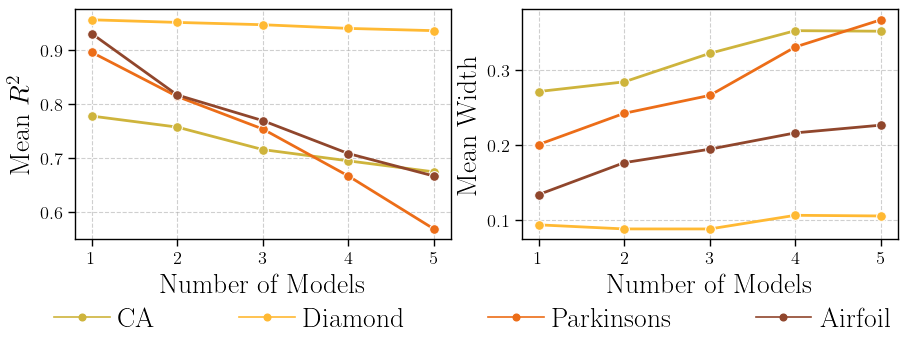

In [924]:
sns.set_context("paper", font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(9,3))
df['size'] = df['n_model'] * 10000

# main plots
# sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], marker='o', hue='data')
# sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], marker='o', hue='data', legend=False)
# sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], style='data', color='orange', marker='o')
# sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], style='data', color='orange', legend=False)

sns.lineplot(data=df, x='n_model', y='top_k_preds_mean', ax=axes[0], hue='data', marker='o', palette=data_colors_dict, legend=False, linewidth=2, markersize=7)
sns.lineplot(data=df, x='n_model', y='mean_width_scaled_mean', ax=axes[1], marker='o', hue='data', palette=data_colors_dict, legend=False, linewidth=2, markersize=7)
# error bars
# for data, color in zip(df['data'].unique(), sns.color_palette()):
#     data_df = df[df['data'] == data]
#     axes[0].errorbar(data_df['n_boot'], data_df['mean_width_scaled_mean'], yerr=data_df['mean_width_scaled_std'], fmt='none', capsize=3, ecolor=color)
#     axes[1].errorbar(data_df['n_boot'], data_df['coverage_mean'], yerr=data_df['coverage_std'], fmt='none', capsize=3, ecolor=color)



# make legend
handles = []
unique_methods = df['data'].unique()
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], 
                              marker='o', color=data_colors_dict[method], 
                              label=method, linestyle='-'))
legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=3, fontsize=20, 
            ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.16),
            handletextpad=0.3, borderaxespad=0.3, frameon=False)

# some customization
#axes[0].legend(title="", loc='lower center', bbox_to_anchor=(1.05, -0.42), ncol=5, frameon=False)
axes[0].set_xlabel("Number of Models", fontsize=20)
axes[0].set_ylabel(r"Mean $R^2$", fontsize=20)
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].set_xlabel("Number of Models", fontsize=20)
axes[1].set_ylabel("Mean Width", fontsize=20)
#axes[1].axhline(0.9, color='black', linestyle='--')
axes[1].grid(True, linestyle='--', alpha=0.6)

fig.tight_layout(pad=0.3)
fig.savefig('figures/ablation_model.pdf', bbox_inches='tight')

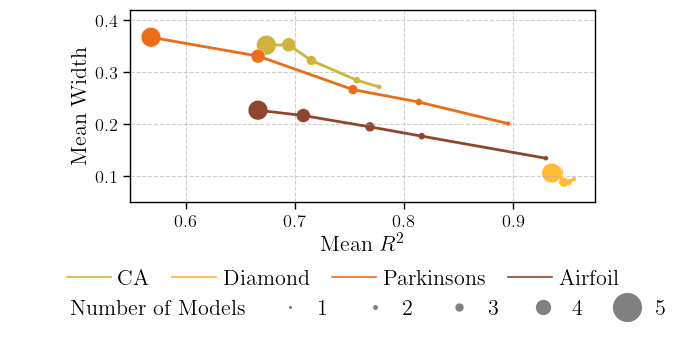

In [557]:
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
df['size'] = df['n_model']

# main plots
# sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], marker='o', hue='data')
# sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], marker='o', hue='data', legend=False)
# sns.lineplot(data=df, x='n_boot', y='mean_width_scaled_mean', ax=axes[0], style='data', color='orange', marker='o')
# sns.lineplot(data=df, x='n_boot', y='coverage_mean', ax=axes[1], style='data', color='orange', legend=False)

# sns.lineplot(data=df, x='n_model', y='mean_width_scaled_mean', ax=axes[0], hue='data', marker='o', palette=data_colors_dict, legend=False)
# sns.lineplot(data=df, x='n_model', y='top_k_preds_mean', ax=axes[1], marker='o', hue='data', palette=data_colors_dict, legend=False)
# error bars
# for data, color in zip(df['data'].unique(), sns.color_palette()):
#     data_df = df[df['data'] == data]
#     axes[0].errorbar(data_df['n_boot'], data_df['mean_width_scaled_mean'], yerr=data_df['mean_width_scaled_std'], fmt='none', capsize=3, ecolor=color)
#     axes[1].errorbar(data_df['n_boot'], data_df['coverage_mean'], yerr=data_df['coverage_std'], fmt='none', capsize=3, ecolor=color)
sns.lineplot(data=df, x='top_k_preds_mean', y='mean_width_scaled_mean', ax=ax, hue='data', palette=data_colors_dict, legend=False, linewidth=2)
sns.scatterplot(data=df, x='top_k_preds_mean', y='mean_width_scaled_mean', ax=ax, hue='data', 
                palette=data_colors_dict, legend=False, size='size', 
                sizes=[12.5, 25, 50, 100, 200],
                marker='o')


# make legend
handles = []
unique_methods = df['data'].unique()
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], 
                              marker=None, color=data_colors_dict[method], 
                              label=method, linestyle='-'))
legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=1, fontsize=16, 
            ncol=len(unique_methods), bbox_to_anchor=(0.48, -0.3),
            handletextpad=0.3, borderaxespad=0.3, frameon=False)

# Add legend for sizes
size_handles = [
    plt.Line2D([0], [0], marker=None, label='Number of Models', markersize=0, linewidth=0),
    plt.Line2D([0], [0], marker='o', color='gray', label='1', markersize=1.25, linewidth=0),
    plt.Line2D([0], [0], marker='o', color='gray', label='2', markersize=2.5, linewidth=0),
    plt.Line2D([0], [0], marker='o', color='gray', label='3', markersize=5, linewidth=0),
    plt.Line2D([0], [0], marker='o', color='gray', label='4', markersize=10, linewidth=0),
    plt.Line2D([0], [0], marker='o', color='gray', label='5', markersize=20, linewidth=0)
]
fig.legend(size_handles, [h.get_label() for h in size_handles], title="", loc='lower center', 
            title_fontsize='small', columnspacing=1, fontsize=16, 
            ncol=6, bbox_to_anchor=(0.48, -0.42),
            handletextpad=0.3, borderaxespad=0.3, frameon=False)

# some customization
#axes[0].legend(title="", loc='lower center', bbox_to_anchor=(1.05, -0.42), ncol=5, frameon=False)
ax.set_xlabel(r"Mean $R^2$", fontsize=16)
ax.set_ylabel("Mean Width", fontsize=16)
ax.set_ylim(0.05, 0.42)
ax.grid(True, linestyle='--', alpha=0.6)



#fig.savefig('figures/ablation_model.pdf', bbox_inches='tight')

# Ablation Experiment 4: Using Additive Calibration

In [930]:
DATASETS = ["data_ca_housing", "data_airfoil", "data_miami_housing", "data_concrete", "data_insurance", "data_diamond","data_parkinsons"]
SEEDS = [777, 778, 779, 780, 781, 782, 783, 784, 785, 786]
RESULT_PATH = Path('../results/ablation/calib')
CALIBS = ['additive', 'multiplicative']

In [931]:
def agg_subgroup_results(dataset_name=None, results_dir="experiments/results/ablation", train_size=0.8, n_boot=1000, train_frac=1, n_model=1, calibration_method='multiplicative'):
    """
    Aggregate results across all seeds for a given dataset and method.
    
    Parameters:
    -----------
    dataset_name : str, optional
        Name of the dataset to aggregate results for. If None, aggregates for all datasets.
    results_dir : str, default="experiments/results/regression"
        Directory where results are stored.
    train_size : float, default=0.8
        Train size used in the experiments.
    """
    import pickle
    import numpy as np
    import math
    from pathlib import Path
    
    results_path = Path(results_dir)
    
    # If dataset_name is None, process all datasets
    if dataset_name is None:
        datasets = [d.name for d in results_path.iterdir() if d.is_dir()]
    else:
        datasets = [dataset_name]
    
    for dataset in datasets:
        dataset_path = results_path / dataset
        if not dataset_path.exists():
            print(f"Dataset path {dataset_path} does not exist. Skipping.")
            continue
        # Find all unique methods by looking at the metrics files
        all_files = list(dataset_path.glob(f"*_seed_*_train_size_{train_size}_nboot_{n_boot}_train_frac_{train_frac}_nmodel_{n_model}_calib_{calibration_method}_ablation_subgroup_metrics.pkl"))
        methods = set()
        for file in all_files:
            # Extract method name from filename
            filename = file.name
            method_name = filename.split("_seed_")[0]
            methods.add(method_name)
        
        # For each method, aggregate results across seeds
        for method in methods:
            print(f"Aggregating results for {method} on {dataset}")
            
            # Find all seed files for this method
            method_files = list(dataset_path.glob(f"{method}_seed_*_train_size_{train_size}_nboot_{n_boot}_train_frac_{train_frac}_nmodel_{n_model}_calib_{calibration_method}_ablation_subgroup_metrics.pkl"))
            
            if not method_files:
                print(f"No files found for method {method}. Skipping.")
                continue
            
            # Load all metrics
            all_var_metrics = []
            seeds = []
            for file in method_files:
                # Extract seed from filename
                filename = file.name
                seed = int(filename.split("_seed_")[1].split("_train_size_")[0])
                seeds.append(seed)
                with open(file, 'rb') as f:
                    var_metrics = pickle.load(f)
                    all_var_metrics.append(var_metrics)
            
            agg_metrics = {}
            for var in all_var_metrics[0].keys():
                var_metrics = {}
                for var_group in all_var_metrics[0][var].keys():
                    var_group_metrics = {}
                    for key in all_var_metrics[0][var][var_group].keys():
                        try:
                            values = [m.get(var).get(var_group).get(key) for m in all_var_metrics]
                            var_group_metrics[key] = {
                                'mean': np.mean(values),
                                'std': np.std(values),
                                'values': values,
                                'seeds': seeds
                            }
                        except:
                            var_group_metrics[key] = {
                                'mean': np.nan,
                                'std': np.nan,
                                'values': np.nan,
                                'seeds': np.nan
                            }
                    var_metrics[var_group] = var_group_metrics
                agg_metrics[var] = var_metrics
            # Save aggregated metrics
            agg_file = f'{dataset_path}/{method}_train_size_{train_size}_nboot_{n_boot}_train_frac_{train_frac}_nmodel_{n_model}_calib_{calibration_method}_ablation_subgroup_agg_metrics.pkl'
            with open(agg_file, 'wb') as f:
                pickle.dump(agg_metrics, f)
            
            print(f"Saved aggregated metrics to {agg_file}")

In [828]:
agg_subgroup_results(dataset_name=None, results_dir="../results/ablation/calib", train_size=0.8, n_boot=1000, train_frac=1.0, n_model=1, calibration_method='multiplicative')

Aggregating results for pcs_oob on data_miami_housing
Saved aggregated metrics to ../results/ablation/calib/data_miami_housing/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_multiplicative_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_diamond
Saved aggregated metrics to ../results/ablation/calib/data_diamond/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_multiplicative_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_concrete


/accounts/campus/michaelxiao1999/.conda/envs/pcs_uq/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Saved aggregated metrics to ../results/ablation/calib/data_concrete/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_multiplicative_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_ca_housing
Saved aggregated metrics to ../results/ablation/calib/data_ca_housing/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_multiplicative_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_airfoil
Saved aggregated metrics to ../results/ablation/calib/data_airfoil/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_multiplicative_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_parkinsons
Saved aggregated metrics to ../results/ablation/calib/data_parkinsons/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_multiplicative_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_insurance
Saved aggregated metrics to ../results/ablation/calib/data_insurance/pcs_

In [829]:
agg_subgroup_results(dataset_name=None, results_dir="../results/ablation/calib", train_size=0.8, n_boot=1000, train_frac=1.0, n_model=1, calibration_method='additive')

Aggregating results for pcs_oob on data_miami_housing
Saved aggregated metrics to ../results/ablation/calib/data_miami_housing/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_additive_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_diamond
Saved aggregated metrics to ../results/ablation/calib/data_diamond/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_additive_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_concrete
Saved aggregated metrics to ../results/ablation/calib/data_concrete/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_additive_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_ca_housing
Saved aggregated metrics to ../results/ablation/calib/data_ca_housing/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_additive_ablation_subgroup_agg_metrics.pkl
Aggregating results for pcs_oob on data_airfoil
Saved aggregated metrics to ../results/ablat

In [890]:
agg_results_dict = {}
for data in DATASETS:
    for calib in CALIBS:
        agg_results_dict[(data, calib)] = {}
        dataset_path = RESULT_PATH / data
        file = pickle.load(open(f'{dataset_path}/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_{calib}_ablation_agg_metrics.pkl', 'rb'))
        for metric_cat, metric_dict in file.items():
            for metric_name, metric_value in metric_dict.items():
                if metric_name in ['values', 'seeds']:
                    continue
                agg_results_dict[(data, calib)][f'{metric_cat}_{metric_name}'] = metric_value

In [891]:
df = pd.DataFrame.from_dict(agg_results_dict, orient='index')
df = df.reset_index().rename(columns={"level_0": "data",
                                      'level_1': "calibration"})
df['data'] = df['data'].map(lambda x: x.split('_')[1].capitalize())
df.loc[df['data'] == 'Ca', 'data'] = 'CA'

In [932]:
agg_sg_results_dict = {}
for data in DATASETS:
    for calib in CALIBS:
        agg_results_dict = {}
        dataset_path = RESULT_PATH / data
        file = pickle.load(open(f'{dataset_path}/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_{calib}_ablation_subgroup_agg_metrics.pkl', 'rb'))
        for sg_var, sg_var_dict in file.items():
            for sg_var_group, sg_var_group_dict in sg_var_dict.items():
                agg_sg_results_dict[(data, calib, sg_var, sg_var_group)] = {}
                for metric_cat, metric_dict in sg_var_group_dict.items():
                    for metric_name, metric_value in metric_dict.items():
                        if metric_name in ['values', 'seeds']:
                            continue
                        agg_sg_results_dict[(data, calib, sg_var, sg_var_group)][f'{metric_cat}_{metric_name}'] = metric_value
        
        

In [933]:
df = pd.DataFrame.from_dict(agg_sg_results_dict, orient='index')
df = df.reset_index().rename(columns={"level_0": "data",
                                      'level_1': "calibration",
                                      'level_2': "sg_var",
                                      'level_3': "SG_Group"})
df['data'] = df['data'].map(lambda x: x.split('_')[1].capitalize())
df.loc[df['data'] == 'Ca', 'data'] = 'CA'

In [934]:
colors_dict = {'additive': 'orange', 'multiplicative': 'orange'}
markers_dict = {'additive': 'P', 'multiplicative': 'X'}
colors_dict_formal = {'Additive': 'orange', 'Multiplicative': 'orange'}
markers_dict_formal = {'Additive': 'P', 'Multiplicative': 'X'}
informal_to_formal = {'additive': 'Additive', 'multiplicative': 'Multiplicative'}

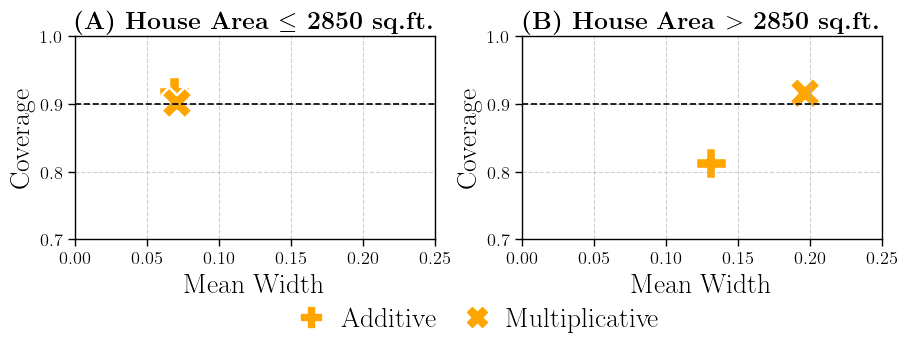

In [936]:
data = 'Miami'
sg_select = [0,1]
sg_var = 'TOT_LVG_AREA'
group_list = [r'(A) House Area $\leq$ 2850 sq.ft.', r'(B) House Area $>$ 2850 sq.ft.']
sg_df = df[(df['data'] == data) & (df['sg_var'] == sg_var)]
xlims = [0,0.25]
ylims = [0.7,1]
methods = ['additive', 'multiplicative']

# make plot
sns.set_context("paper", font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(9,3))

# make legend
handles = []
unique_methods = [informal_to_formal[method] for method in methods]
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], marker=markers_dict_formal[method], color=colors_dict_formal[method], label=method, markersize=14, linestyle='None'))

legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=0.5, fontsize=20, 
            ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.16), # -0.14, 1.15
            handletextpad=0.05, borderaxespad=0.3, frameon=False)

# if multiple subgroups, take only the two in the sg_select list
if sg_select is not None:
    sg_groups = sg_df['SG_Group'].unique()[sg_select]
else:
    if len(sg_df['SG_Group'].unique()) != 2:
        raise ValueError('Subgroup plot only supports 2 subgroups')
    else:
        sg_groups = sg_df['SG_Group'].unique()
    
for i, sg in enumerate(sg_groups):
    sg_plot = sg_df[sg_df['SG_Group'] == sg]
    legend = False
    sns.scatterplot(data=sg_plot, x='mean_width_scaled_mean', y='coverage_mean',
                    hue='calibration', style='calibration', ax=axes[i],
                    palette=colors_dict, markers=markers_dict,
                    legend=legend, s=500)
    axes[i].set_title(r'\textbf{' + group_list[i] + '}', loc='center', fontsize=18, fontweight='black')

for ax in axes:
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    #ax.set_yticks(np.arange(0.7, 1.05, 0.1))
    ax.axhline(0.9, linestyle='dashed', color='black')
    ax.set_ylabel('Coverage', fontsize=20)
    ax.set_xlabel('Mean Width', fontsize=20)
    ax.grid(True, linestyle='--', alpha=0.6)   

fig.tight_layout(pad=0.3)
fig.savefig('figures/ablation_calib_miami.pdf', bbox_inches='tight')

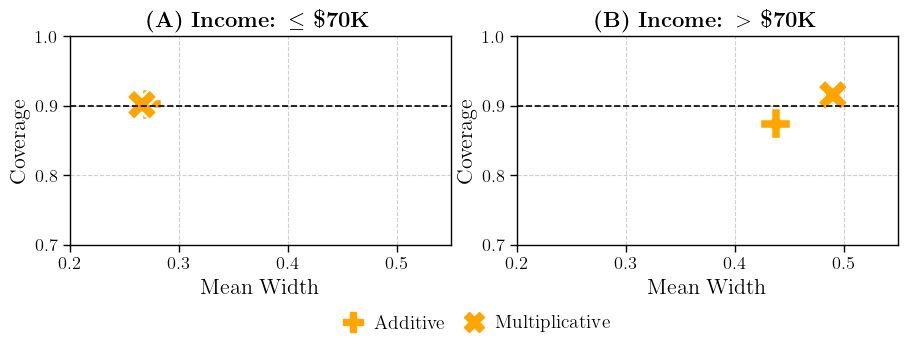

In [842]:
data = 'CA'
sg_select = [0,1]
sg_var = 'med_income'
group_list = [r'(A) Income: $\leq$ \$70K', r'(B) Income: $>$ \$70K']
sg_df = df[(df['data'] == data) & (df['sg_var'] == sg_var)]
xlims = [0.2,0.55]
ylims = [0.7,1]
methods = ['additive', 'multiplicative']

# make plot
sns.set_context("paper", font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# make legend
handles = []
unique_methods = [informal_to_formal[method] for method in methods]
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], marker=markers_dict_formal[method], color=colors_dict_formal[method], label=method, markersize=14, linestyle='None'))

legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=0.5, fontsize=14, 
            ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.14), # -0.14, 1.15
            handletextpad=0.05, borderaxespad=0.3, frameon=False)

# if multiple subgroups, take only the two in the sg_select list
if sg_select is not None:
    sg_groups = sg_df['SG_Group'].unique()[sg_select]
else:
    if len(sg_df['SG_Group'].unique()) != 2:
        raise ValueError('Subgroup plot only supports 2 subgroups')
    else:
        sg_groups = sg_df['SG_Group'].unique()
    
for i, sg in enumerate(sg_groups):
    sg_plot = sg_df[sg_df['SG_Group'] == sg]
    legend = False
    sns.scatterplot(data=sg_plot, x='mean_width_scaled_mean', y='coverage_mean',
                    hue='calibration', style='calibration', ax=axes[i],
                    palette=colors_dict, markers=markers_dict,
                    legend=legend, s=500)
    axes[i].set_title(r'\textbf{' + group_list[i] + '}', loc='center', fontsize=16, fontweight='black')

for ax in axes:
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    #ax.set_yticks(np.arange(0.7, 1.05, 0.1))
    ax.axhline(0.9, linestyle='dashed', color='black')
    ax.set_ylabel('Coverage', fontsize=16)
    ax.set_xlabel('Mean Width', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)   

fig.tight_layout(pad=0.3)
# if save_path is not None:
#     fig.savefig(save_path, bbox_inches='tight')
# fig.show()

In [843]:
np.sort(sg_groups)

array([Interval(0.0, 7.0, closed='right'),
       Interval(7.0, 9.5, closed='right')], dtype=object)

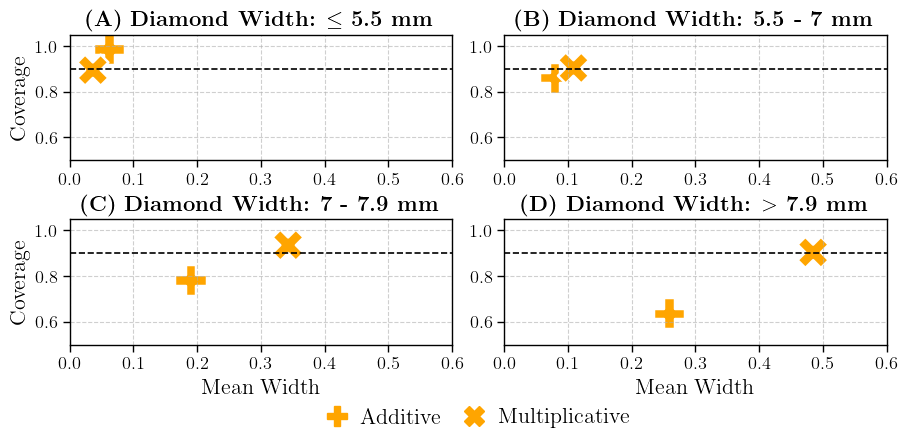

In [865]:
data = 'Diamond'
# sg_select = [2,3]
sg_select=None
sg_var = 'y'
group_list = [r'(A) Diamond Width: $\leq$ 5.5 mm', r'(B) Diamond Width: 5.5 - 7 mm', r'(C) Diamond Width: 7 - 7.9 mm', r'(D) Diamond Width: $>$ 7.9 mm']
sg_df = df[(df['data'] == data) & (df['sg_var'] == sg_var)]
xlims = [0, 0.6]
ylims = [0.5, 1.05]
methods = ['additive', 'multiplicative']

# make plot
sns.set_context("paper", font_scale=1.5)
fig, axes = plt.subplots(2, 2, figsize=(9, 4))

# make legend
handles = []
unique_methods = [informal_to_formal[method] for method in methods]
for method in unique_methods:
    handles.append(plt.Line2D([0], [0], marker=markers_dict_formal[method], color=colors_dict_formal[method], label=method, markersize=14, linestyle='None'))

legend_labels = unique_methods
fig.legend(handles, legend_labels, title="", loc='lower center', 
            title_fontsize='small', columnspacing=0.5, fontsize=16, 
            ncol=len(unique_methods), bbox_to_anchor=(0.52, -0.1), # -0.14, 1.15
            handletextpad=0.05, borderaxespad=0.3, frameon=False)

# if multiple subgroups, take only the two in the sg_select list
if sg_select is not None:
    sg_groups = sg_df['SG_Group'].unique()[sg_select]
else:
    if len(sg_df['SG_Group'].unique()) != 4:
        raise ValueError('Subgroup plot only supports 4 subgroups')
    else:
        sg_groups = np.sort(sg_df['SG_Group'].unique())
    
for i, ax in enumerate(axes.flatten()):
    sg_plot = sg_df[sg_df['SG_Group'] == sg_groups[i]]
    legend = False
    sns.scatterplot(data=sg_plot, x='mean_width_scaled_mean', y='coverage_mean',
                    hue='calibration', style='calibration', ax=ax,
                    palette=colors_dict, markers=markers_dict,
                    legend=legend, s=500)
    ax.set_title(r'\textbf{' + group_list[i] + '}', loc='center', fontsize=16, fontweight='black')

for ax in axes.flatten():
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    #ax.set_yticks(np.arange(0.7, 1.05, 0.1))
    ax.axhline(0.9, linestyle='dashed', color='black')
    ax.set_ylabel('Coverage', fontsize=16)
    ax.set_xlabel('Mean Width', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)   

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')

fig.tight_layout(pad=0.3)
fig.savefig('figures/ablation_calib_diamond.pdf', bbox_inches='tight')

In [856]:
file = pickle.load(open('../results/ablation/calib/data_miami_housing/pcs_oob_train_size_0.8_nboot_1000_train_frac_1.0_nmodel_1_calib_additive_ablation_subgroup_agg_metrics.pkl', 'rb'))

In [857]:
file['TOT_LVG_AREA'].keys()

dict_keys([Interval(0, 2850, closed='right'), Interval(2850, 10000, closed='right')])